# Trainning Isolation Forest on specific dataset sizes
* Dataset       : KDDCUP99 100%
* Subset        : SA
* Total size    :  
* Features      : 41
* Key attribute : 

In [2]:
from imports import *

In [3]:
from sklearn.metrics import precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
import time
import statistics

In [4]:
df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
print(f"{df.columns}")
print(np.array(df.head(1)))

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'target'],
      dtype='object')
[[0 'tcp' 'http' 'SF' 162 4528 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 2 0.0
  0.0 0.0 0.0 1.0 0.0 0.0 1 1 1.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 'normal.']]


In [4]:
scoring = {'AUC': 'roc_auc',
           'Precision': make_scorer(precision_score, pos_label=1), 
           'Recall': make_scorer(recall_score, pos_label=-1),
           'F1': make_scorer(f1_score, average='weighted')}

In [5]:
dfsf = df[df["logged_in"]== 1]
print(len(dfsf)- len(dfsf.loc[dfsf["target"]=='normal.']))
dfsf = dfsf[sf_columns + ["target"]] 
# print(dfsf.head(1))
# Split the dataset into 2 classes for consistent anomaly_rate when sampling
dfsf_normal = dfsf.loc[dfsf["target"]=='normal.']
dfsf_attack = dfsf.loc[dfsf["target"]!='normal.']
# print(f"A sample normal frame: \t {dfsf_normal.head(1)}")
# print("-----------------")
# print(f"A sample attack frame: \t {dfsf_attack.head(1)}")


3377


In [6]:
def cross_validation(contamination, max_samples, n_estimators, random_state, silent=True):
    highest_score = 0
    highest_score_c = 0
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = IsolationForest(random_state= random_state, n_jobs=-1, max_samples = max_samples, n_estimators = n_estimators, contamination=c).fit(x_train).predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        f = f1_score(y_test, y_pred, average = "macro")
        r = recall_score(y_test, y_pred, pos_label = -1)
        a = roc_auc_score(y_test, y_pred)
        if a > highest_score: highest_score = a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        
        fp = tp / p - tp
        # predicted true
        positives = yp[np.where(yp == -1)]
        if not silent:
            print(f"Finished trainning in {t} seconds")
            print(f"contamination: {c} \t tp: {tp}/support: {s}/predicted: {len(positives)} -> fp = {len(positives) - tp}")
            print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
            print("--------------------")
    return (highest_score_c, y_pred, f, len(positives) - tp, tp, p, r, t)

In [7]:
stat_auc = []
stat_f1 = []
stat_r = []

## Configuration 1
* frac_oulier = 0.1
* frac_normal = 0.1
* r = 0.01
* random_state = 1
* IF random_state = 1

In [8]:
frac_oulier = 0.1
frac_normal = 0.1

dfsf_frac = dfsf_normal.sample(frac = frac_normal, random_state = 1).append(dfsf_attack.sample(frac = frac_oulier, random_state = 1))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")

dfsf_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsf_frac["target"]]
toDecode = toDecodeSF
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsf_frac[f] = leSF.fit_transform(dfsf_frac[f])
    
    
Y_source = []
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

hyperparameters = [(1, 0.25, 100),
                           (2, 0.25, 200),
                           (3, 0.25, 500),
                           (4, 0.5, 100),
                           (5, 0.5, 200),
                           (6, 0.25, 1000)]

for rs, max_samples, n_estimators in hyperparameters:
    contaminations = np.arange(0.05 - (rs * 0.005), 0.4, 0.02)
    x_train, x_test, y_train, y_test = train_test_split(dfsf_frac.drop(["target", "binary_target"], axis=1), dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
    stime = time.time()
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False)
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    Y_source.append((y_test, y_pred))
    best_param.append((rs, cmax, max_samples, n_estimators))
    print(rs, cmax, max_samples, n_estimators)

anomaly rate is 0.5% out of 70307 records
Finished trainning in 0:00:02.892635 seconds
contamination: 0.045000000000000005 	 tp: 78/support: 97/predicted: 791 -> fp = 713
AUC : 88.2% 	 precision: 0.0986 	 recall: 0.804 	 f1: 0.5771566961813854
--------------------
Finished trainning in 0:00:03.069755 seconds
contamination: 0.065 	 tp: 78/support: 97/predicted: 1104 -> fp = 1026
AUC : 87.3% 	 precision: 0.0707 	 recall: 0.804 	 f1: 0.5495569584570217
--------------------
Finished trainning in 0:00:03.648308 seconds
contamination: 0.08499999999999999 	 tp: 79/support: 97/predicted: 1419 -> fp = 1340
AUC : 86.9% 	 precision: 0.0557 	 recall: 0.814 	 f1: 0.5319253134529817
--------------------
Finished trainning in 0:00:03.135841 seconds
contamination: 0.105 	 tp: 97/support: 97/predicted: 1733 -> fp = 1636
AUC : 95.3% 	 precision: 0.056 	 recall: 1.0 	 f1: 0.5284585913563995
--------------------
Finished trainning in 0:00:03.086275 seconds
contamination: 0.125 	 tp: 97/support: 97/predict

Finished trainning in 0:00:15.777343 seconds
contamination: 0.09500000000000001 	 tp: 76/support: 84/predicted: 1635 -> fp = 1559
AUC : 90.8% 	 precision: 0.0465 	 recall: 0.905 	 f1: 0.5207782232776419
--------------------
Finished trainning in 0:00:15.610792 seconds
contamination: 0.11500000000000002 	 tp: 84/support: 84/predicted: 2010 -> fp = 1926
AUC : 94.5% 	 precision: 0.0418 	 recall: 1.0 	 f1: 0.5109857565561964
--------------------
Finished trainning in 0:00:15.290061 seconds
contamination: 0.135 	 tp: 84/support: 84/predicted: 2345 -> fp = 2261
AUC : 93.5% 	 precision: 0.0358 	 recall: 1.0 	 f1: 0.5000366780193869
--------------------
Finished trainning in 0:00:15.558998 seconds
contamination: 0.15500000000000003 	 tp: 84/support: 84/predicted: 2695 -> fp = 2611
AUC : 92.5% 	 precision: 0.0312 	 recall: 1.0 	 f1: 0.48990237592756486
--------------------
Finished trainning in 0:00:15.846068 seconds
contamination: 0.17500000000000002 	 tp: 84/support: 84/predicted: 3033 -> fp 

Finished trainning in 0:00:06.434194 seconds
contamination: 0.08499999999999999 	 tp: 82/support: 92/predicted: 1558 -> fp = 1476
AUC : 90.3% 	 precision: 0.0526 	 recall: 0.891 	 f1: 0.5275205131544674
--------------------
Finished trainning in 0:00:06.749480 seconds
contamination: 0.10499999999999998 	 tp: 92/support: 92/predicted: 1867 -> fp = 1775
AUC : 94.9% 	 precision: 0.0493 	 recall: 1.0 	 f1: 0.5202267818798704
--------------------
Finished trainning in 0:00:07.558963 seconds
contamination: 0.12499999999999997 	 tp: 92/support: 92/predicted: 2233 -> fp = 2141
AUC : 93.9% 	 precision: 0.0412 	 recall: 1.0 	 f1: 0.5069615279173901
--------------------
Finished trainning in 0:00:07.047146 seconds
contamination: 0.145 	 tp: 92/support: 92/predicted: 2591 -> fp = 2499
AUC : 92.9% 	 precision: 0.0355 	 recall: 1.0 	 f1: 0.4958094836261647
--------------------
Finished trainning in 0:00:06.459541 seconds
contamination: 0.16499999999999998 	 tp: 92/support: 92/predicted: 2890 -> fp =

In [9]:
f1_tuned = []
auc_tuned = []
r_tuned = []

Y_source_1 = Y_source
for y_test, y_pred in Y_source:
    f  = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)

m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
stat_auc.append((m, s))
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
stat_f1.append((m, s))
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")
stat_r.append((m, s))

              precision    recall  f1-score   support

          -1       0.01      1.00      0.03        97
           1       1.00      0.62      0.77     17480

    accuracy                           0.63     17577
   macro avg       0.51      0.81      0.40     17577
weighted avg       0.99      0.63      0.76     17577

---0.7639359711599744, 0.39832129353397283
---0.8116990846681922
---0.8116990846681922
              precision    recall  f1-score   support

          -1       0.01      1.00      0.03        86
           1       1.00      0.63      0.77     17491

    accuracy                           0.63     17577
   macro avg       0.51      0.81      0.40     17577
weighted avg       1.00      0.63      0.77     17577

---0.7660715317659224, 0.39765377716817896
---0.8128180206963581
---0.8128180206963581
              precision    recall  f1-score   support

          -1       0.01      1.00      0.02        84
           1       1.00      0.61      0.76     17493

    accu

In [10]:
frac_oulier = 0.1
frac_normal = 0.2

dfsf_frac = dfsf_normal.sample(frac = frac_normal, random_state = 1).append(dfsf_attack.sample(frac = frac_oulier, random_state = 1))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")

dfsf_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsf_frac["target"]]
toDecode = toDecodeSF
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsf_frac[f] = leSF.fit_transform(dfsf_frac[f])
        
Y_source = []
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

hyperparameters = [(1, 0.25, 100),(2, 0.25, 200),(3, 0.25, 500),(4, 0.5, 100),(5, 0.5, 200),(6, 0.25, 1000)]

for rs, max_samples, n_estimators in hyperparameters:
    contaminations = np.arange(0.05 - (rs * 0.005), 0.4, 0.02)
    x_train, x_test, y_train, y_test = train_test_split(dfsf_frac.drop(["target", "binary_target"], axis=1), dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
    stime = time.time()
    
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False)
    
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    Y_source.append((y_test, y_pred))
    best_param.append((rs, cmax, max_samples, n_estimators))
    print(rs, cmax, max_samples, n_estimators)

anomaly rate is 0.2% out of 140276 records
Finished trainning in 0:00:05.843321 seconds
contamination: 0.045000000000000005 	 tp: 80/support: 97/predicted: 1571 -> fp = 1491
AUC : 89.1% 	 precision: 0.0509 	 recall: 0.825 	 f1: 0.5369495085981747
--------------------
Finished trainning in 0:00:06.284387 seconds
contamination: 0.065 	 tp: 80/support: 97/predicted: 2253 -> fp = 2173
AUC : 88.1% 	 precision: 0.0355 	 recall: 0.825 	 f1: 0.5178892517222028
--------------------
Finished trainning in 0:00:05.826262 seconds
contamination: 0.08499999999999999 	 tp: 97/support: 97/predicted: 2922 -> fp = 2825
AUC : 96.0% 	 precision: 0.0332 	 recall: 1.0 	 f1: 0.5110851326877313
--------------------
Finished trainning in 0:00:05.931318 seconds
contamination: 0.105 	 tp: 97/support: 97/predicted: 3579 -> fp = 3482
AUC : 95.0% 	 precision: 0.0271 	 recall: 1.0 	 f1: 0.5001919576451174
--------------------
Finished trainning in 0:00:05.819113 seconds
contamination: 0.125 	 tp: 97/support: 97/predi

Finished trainning in 0:00:29.238364 seconds
contamination: 0.05500000000000001 	 tp: 63/support: 76/predicted: 1862 -> fp = 1799
AUC : 88.9% 	 precision: 0.0338 	 recall: 0.829 	 f1: 0.5192232824600747
--------------------
Finished trainning in 0:00:31.809307 seconds
contamination: 0.07500000000000001 	 tp: 63/support: 76/predicted: 2536 -> fp = 2473
AUC : 87.9% 	 precision: 0.0248 	 recall: 0.829 	 f1: 0.5057117242662449
--------------------
Finished trainning in 0:00:29.198834 seconds
contamination: 0.09500000000000001 	 tp: 74/support: 76/predicted: 3187 -> fp = 3113
AUC : 94.2% 	 precision: 0.0232 	 recall: 0.974 	 f1: 0.49938879707625283
--------------------
Finished trainning in 0:00:29.256191 seconds
contamination: 0.11500000000000002 	 tp: 74/support: 76/predicted: 4003 -> fp = 3929
AUC : 93.1% 	 precision: 0.0185 	 recall: 0.974 	 f1: 0.4883879963761325
--------------------
Finished trainning in 0:00:29.832460 seconds
contamination: 0.135 	 tp: 75/support: 76/predicted: 4736 

Finished trainning in 0:00:12.436685 seconds
contamination: 0.045 	 tp: 69/support: 84/predicted: 1600 -> fp = 1531
AUC : 88.9% 	 precision: 0.0431 	 recall: 0.821 	 f1: 0.5296816170812072
--------------------
Finished trainning in 0:00:12.622790 seconds
contamination: 0.065 	 tp: 69/support: 84/predicted: 2340 -> fp = 2271
AUC : 87.8% 	 precision: 0.0295 	 recall: 0.821 	 f1: 0.5115855284763494
--------------------
Finished trainning in 0:00:12.587101 seconds
contamination: 0.08499999999999999 	 tp: 83/support: 84/predicted: 3067 -> fp = 2984
AUC : 95.1% 	 precision: 0.0271 	 recall: 0.988 	 f1: 0.5040604017025391
--------------------
Finished trainning in 0:00:13.202455 seconds
contamination: 0.10499999999999998 	 tp: 83/support: 84/predicted: 3784 -> fp = 3701
AUC : 94.1% 	 precision: 0.0219 	 recall: 0.988 	 f1: 0.49352692730640796
--------------------
Finished trainning in 0:00:12.927269 seconds
contamination: 0.12499999999999997 	 tp: 83/support: 84/predicted: 4465 -> fp = 4382
A

In [11]:
f1_tuned = []
auc_tuned = []
r_tuned = []

Y_source_1 = Y_source
for y_test, y_pred in Y_source:
    f  = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)

m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
stat_auc.append((m, s))
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
stat_f1.append((m, s))
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")
stat_r.append((m, s))

              precision    recall  f1-score   support

          -1       0.01      1.00      0.01        97
           1       1.00      0.62      0.76     34972

    accuracy                           0.62     35069
   macro avg       0.50      0.81      0.39     35069
weighted avg       1.00      0.62      0.76     35069

---0.7614688313432894, 0.3889187332151719
---0.8087612947500857
---0.8087612947500857
              precision    recall  f1-score   support

          -1       0.01      1.00      0.01        70
           1       1.00      0.63      0.77     34999

    accuracy                           0.63     35069
   macro avg       0.50      0.81      0.39     35069
weighted avg       1.00      0.63      0.77     35069

---0.7688951106828538, 0.39050488998361316
---0.8132803794394126
---0.8132803794394126
              precision    recall  f1-score   support

          -1       0.01      1.00      0.01        76
           1       1.00      0.61      0.76     34993

    accur

In [12]:
frac_oulier = 0.1
frac_normal = 0.5

dfsf_frac = dfsf_normal.sample(frac = frac_normal, random_state = 1).append(dfsf_attack.sample(frac = frac_oulier, random_state = 1))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")

dfsf_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsf_frac["target"]]
toDecode = toDecodeSF
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsf_frac[f] = leSF.fit_transform(dfsf_frac[f])
        
Y_source = []
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

hyperparameters = [(1, 0.25, 100),(2, 0.25, 200),(3, 0.25, 500),(4, 0.5, 100),(5, 0.5, 200),(6, 0.25, 1000)]

for rs, max_samples, n_estimators in hyperparameters:
    contaminations = np.arange(0.05 - (rs * 0.005), 0.4, 0.02)
    x_train, x_test, y_train, y_test = train_test_split(dfsf_frac.drop(["target", "binary_target"], axis=1), dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
    stime = time.time()
    
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False)
    
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    Y_source.append((y_test, y_pred))
    best_param.append((rs, cmax, max_samples, n_estimators))
    print(rs, cmax, max_samples, n_estimators)

anomaly rate is 0.1% out of 350182 records
Finished trainning in 0:00:14.700027 seconds
contamination: 0.045000000000000005 	 tp: 79/support: 93/predicted: 3935 -> fp = 3856
AUC : 90.3% 	 precision: 0.0201 	 recall: 0.849 	 f1: 0.5083011551139405
--------------------
Finished trainning in 0:00:14.634352 seconds
contamination: 0.065 	 tp: 79/support: 93/predicted: 5626 -> fp = 5547
AUC : 89.3% 	 precision: 0.014 	 recall: 0.849 	 f1: 0.49739717376737846
--------------------
Finished trainning in 0:00:14.563358 seconds
contamination: 0.08499999999999999 	 tp: 92/support: 93/predicted: 7368 -> fp = 7276
AUC : 95.3% 	 precision: 0.0125 	 recall: 0.989 	 f1: 0.4906253742744361
--------------------
Finished trainning in 0:00:14.913528 seconds
contamination: 0.105 	 tp: 93/support: 93/predicted: 9157 -> fp = 9064
AUC : 94.8% 	 precision: 0.0102 	 recall: 1.0 	 f1: 0.48272683899393665
--------------------
Finished trainning in 0:00:14.821801 seconds
contamination: 0.125 	 tp: 93/support: 93/pr

Finished trainning in 0:01:15.004228 seconds
contamination: 0.05500000000000001 	 tp: 70/support: 84/predicted: 4895 -> fp = 4825
AUC : 88.9% 	 precision: 0.0143 	 recall: 0.833 	 f1: 0.49983614910499097
--------------------
Finished trainning in 0:01:15.015099 seconds
contamination: 0.07500000000000001 	 tp: 70/support: 84/predicted: 6615 -> fp = 6545
AUC : 87.9% 	 precision: 0.0106 	 recall: 0.833 	 f1: 0.49097404569363945
--------------------
Finished trainning in 0:01:15.184343 seconds
contamination: 0.09500000000000001 	 tp: 83/support: 84/predicted: 8445 -> fp = 8362
AUC : 94.6% 	 precision: 0.00983 	 recall: 0.988 	 f1: 0.48462688920894303
--------------------
Finished trainning in 0:01:14.017868 seconds
contamination: 0.11500000000000002 	 tp: 83/support: 84/predicted: 10210 -> fp = 10127
AUC : 93.6% 	 precision: 0.00813 	 recall: 0.988 	 f1: 0.4773344210320109
--------------------
Finished trainning in 0:01:17.497367 seconds
contamination: 0.135 	 tp: 84/support: 84/predicted:

Finished trainning in 0:00:32.490890 seconds
contamination: 0.025 	 tp: 63/support: 73/predicted: 2211 -> fp = 2148
AUC : 91.9% 	 precision: 0.0285 	 recall: 0.863 	 f1: 0.5213392634981305
--------------------
Finished trainning in 0:00:31.271574 seconds
contamination: 0.045 	 tp: 63/support: 73/predicted: 3967 -> fp = 3904
AUC : 90.9% 	 precision: 0.0159 	 recall: 0.863 	 f1: 0.5041530940854533
--------------------
Finished trainning in 0:00:31.553663 seconds
contamination: 0.065 	 tp: 64/support: 73/predicted: 5746 -> fp = 5682
AUC : 90.6% 	 precision: 0.0111 	 recall: 0.877 	 f1: 0.49418833005053836
--------------------
Finished trainning in 0:00:32.092253 seconds
contamination: 0.08499999999999999 	 tp: 73/support: 73/predicted: 7372 -> fp = 7299
AUC : 95.8% 	 precision: 0.0099 	 recall: 1.0 	 f1: 0.4880362834083927
--------------------
Finished trainning in 0:00:31.830387 seconds
contamination: 0.10499999999999998 	 tp: 73/support: 73/predicted: 9116 -> fp = 9043
AUC : 94.8% 	 pre

Finished trainning in 0:02:34.649594 seconds
contamination: 0.3800000000000001 	 tp: 73/support: 73/predicted: 33195 -> fp = 33122
AUC : 81.1% 	 precision: 0.0022 	 recall: 1.0 	 f1: 0.38542280940363327
--------------------
Time for IF fitting: 2882.852
6 0.10000000000000002 0.25 1000


In [13]:
f1_tuned = []
auc_tuned = []
r_tuned = []

Y_source_1 = Y_source
for y_test, y_pred in Y_source:
    f  = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)

m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
stat_auc.append((m, s))
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
stat_f1.append((m, s))
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")
stat_r.append((m, s))

              precision    recall  f1-score   support

          -1       0.00      1.00      0.01        93
           1       1.00      0.61      0.76     87453

    accuracy                           0.62     87546
   macro avg       0.50      0.81      0.38     87546
weighted avg       1.00      0.62      0.76     87546

---0.7607751965437096, 0.3835358771085758
---0.8074794461024779
---0.8074794461024779
              precision    recall  f1-score   support

          -1       0.00      1.00      0.01        87
           1       1.00      0.62      0.77     87459

    accuracy                           0.62     87546
   macro avg       0.50      0.81      0.39     87546
weighted avg       1.00      0.62      0.77     87546

---0.7661930847943312, 0.3860928253672151
---0.8109971529516689
---0.8109971529516689
              precision    recall  f1-score   support

          -1       0.00      1.00      0.00        84
           1       1.00      0.60      0.75     87462

    accura

In [14]:
frac_oulier = 0.1
frac_normal = 0.7

dfsf_frac = dfsf_normal.sample(frac = frac_normal, random_state = 1).append(dfsf_attack.sample(frac = frac_oulier, random_state = 1))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")

dfsf_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsf_frac["target"]]
toDecode = toDecodeSF
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsf_frac[f] = leSF.fit_transform(dfsf_frac[f])
        
Y_source = []
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

hyperparameters = [(1, 0.25, 100),(2, 0.25, 200),(3, 0.25, 500),(4, 0.5, 100),(5, 0.5, 200),(6, 0.25, 1000)]

for rs, max_samples, n_estimators in hyperparameters:
    contaminations = np.arange(0.05 - (rs * 0.005), 0.4, 0.02)
    x_train, x_test, y_train, y_test = train_test_split(dfsf_frac.drop(["target", "binary_target"], axis=1), dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
    stime = time.time()
    
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False)
    
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    Y_source.append((y_test, y_pred))
    best_param.append((rs, cmax, max_samples, n_estimators))
    print(rs, cmax, max_samples, n_estimators)

anomaly rate is 0.1% out of 490120 records
Finished trainning in 0:00:21.395905 seconds
contamination: 0.045000000000000005 	 tp: 82/support: 101/predicted: 5463 -> fp = 5381
AUC : 88.4% 	 precision: 0.015 	 recall: 0.812 	 f1: 0.5034639241328429
--------------------
Finished trainning in 0:00:21.953904 seconds
contamination: 0.065 	 tp: 82/support: 101/predicted: 7789 -> fp = 7707
AUC : 87.4% 	 precision: 0.0105 	 recall: 0.812 	 f1: 0.49410500764907783
--------------------
Finished trainning in 0:00:21.920602 seconds
contamination: 0.08499999999999999 	 tp: 100/support: 101/predicted: 10303 -> fp = 10203
AUC : 95.3% 	 precision: 0.00971 	 recall: 0.99 	 f1: 0.4878692222457632
--------------------
Finished trainning in 0:00:25.705481 seconds
contamination: 0.105 	 tp: 100/support: 101/predicted: 12805 -> fp = 12705
AUC : 94.3% 	 precision: 0.00781 	 recall: 0.99 	 f1: 0.4803828784192706
--------------------
Finished trainning in 0:00:21.603303 seconds
contamination: 0.125 	 tp: 100/su

Finished trainning in 0:01:51.699347 seconds
contamination: 0.05500000000000001 	 tp: 58/support: 75/predicted: 6698 -> fp = 6640
AUC : 86.0% 	 precision: 0.00866 	 recall: 0.773 	 f1: 0.494594963743294
--------------------
Finished trainning in 0:01:53.538074 seconds
contamination: 0.07500000000000001 	 tp: 58/support: 75/predicted: 9143 -> fp = 9085
AUC : 85.0% 	 precision: 0.00634 	 recall: 0.773 	 f1: 0.4869952199575148
--------------------
Finished trainning in 0:01:53.726190 seconds
contamination: 0.09500000000000001 	 tp: 75/support: 75/predicted: 11551 -> fp = 11476
AUC : 95.3% 	 precision: 0.00649 	 recall: 1.0 	 f1: 0.48187023427173326
--------------------
Finished trainning in 0:01:54.012638 seconds
contamination: 0.11500000000000002 	 tp: 75/support: 75/predicted: 14017 -> fp = 13942
AUC : 94.3% 	 precision: 0.00535 	 recall: 1.0 	 f1: 0.4751404984182235
--------------------
Finished trainning in 0:01:52.454247 seconds
contamination: 0.135 	 tp: 75/support: 75/predicted: 16

Finished trainning in 0:00:47.081605 seconds
contamination: 0.045 	 tp: 72/support: 85/predicted: 5619 -> fp = 5547
AUC : 90.1% 	 precision: 0.0128 	 recall: 0.847 	 f1: 0.5010082219922195
--------------------
Finished trainning in 0:00:53.876839 seconds
contamination: 0.065 	 tp: 72/support: 85/predicted: 8112 -> fp = 8040
AUC : 89.1% 	 precision: 0.00888 	 recall: 0.847 	 f1: 0.4917844232904631
--------------------
Finished trainning in 0:00:48.512213 seconds
contamination: 0.08499999999999999 	 tp: 72/support: 85/predicted: 10644 -> fp = 10572
AUC : 88.0% 	 precision: 0.00676 	 recall: 0.847 	 f1: 0.4841252104585239
--------------------
Finished trainning in 0:00:46.603446 seconds
contamination: 0.10499999999999998 	 tp: 84/support: 85/predicted: 13078 -> fp = 12994
AUC : 94.1% 	 precision: 0.00642 	 recall: 0.988 	 f1: 0.4783626190238323
--------------------
Finished trainning in 0:00:49.602393 seconds
contamination: 0.12499999999999997 	 tp: 85/support: 85/predicted: 15510 -> fp =

In [15]:
f1_tuned = []
auc_tuned = []
r_tuned = []

Y_source_1 = Y_source
for y_test, y_pred in Y_source:
    f  = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)

m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
stat_auc.append((m, s))
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
stat_f1.append((m, s))
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")
stat_r.append((m, s))

              precision    recall  f1-score   support

          -1       0.00      1.00      0.00       101
           1       1.00      0.62      0.76    122429

    accuracy                           0.62    122530
   macro avg       0.50      0.81      0.38    122530
weighted avg       1.00      0.62      0.76    122530

---0.762168334852142, 0.3835389729572529
---0.8082725498043764
---0.8082725498043764
              precision    recall  f1-score   support

          -1       0.00      1.00      0.00        76
           1       1.00      0.62      0.77    122454

    accuracy                           0.62    122530
   macro avg       0.50      0.81      0.39    122530
weighted avg       1.00      0.62      0.77    122530

---0.7667388161543061, 0.3852443279611032
---0.81116990870041
---0.81116990870041
              precision    recall  f1-score   support

          -1       0.00      1.00      0.00        75
           1       1.00      0.60      0.75    122455

    accuracy   

In [16]:
frac_oulier = 0.1
frac_normal = 1.0

dfsf_frac = dfsf_normal.sample(frac = frac_normal, random_state = 1).append(dfsf_attack.sample(frac = frac_oulier, random_state = 1))

anomaly_rate = 1.0 - len(dfsf_frac.loc[dfsf_frac["target"]=='normal.'])/len(dfsf_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsf_frac)} records")

dfsf_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsf_frac["target"]]
toDecode = toDecodeSF
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsf_frac[f] = leSF.fit_transform(dfsf_frac[f])
        
Y_source = []
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

hyperparameters = [(1, 0.25, 100),(2, 0.25, 200),(3, 0.25, 500),(4, 0.5, 100),(5, 0.5, 200),(6, 0.25, 1000)]

for rs, max_samples, n_estimators in hyperparameters:
    contaminations = np.arange(0.05 - (rs * 0.005), 0.4, 0.02)
    x_train, x_test, y_train, y_test = train_test_split(dfsf_frac.drop(["target", "binary_target"], axis=1), dfsf_frac['binary_target'], test_size=0.25, random_state=rs)
    stime = time.time()
    
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False)
    
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    Y_source.append((y_test, y_pred))
    best_param.append((rs, cmax, max_samples, n_estimators))
    print(rs, cmax, max_samples, n_estimators)

anomaly rate is 0.0% out of 700027 records
Finished trainning in 0:00:32.983053 seconds
contamination: 0.045000000000000005 	 tp: 91/support: 108/predicted: 8075 -> fp = 7984
AUC : 89.8% 	 precision: 0.0113 	 recall: 0.843 	 f1: 0.49941746435368656
--------------------
Finished trainning in 0:00:32.762889 seconds
contamination: 0.065 	 tp: 91/support: 108/predicted: 11554 -> fp = 11463
AUC : 88.9% 	 precision: 0.00788 	 recall: 0.843 	 f1: 0.4908385399840175
--------------------
Finished trainning in 0:00:33.241434 seconds
contamination: 0.08499999999999999 	 tp: 91/support: 108/predicted: 15018 -> fp = 14927
AUC : 87.9% 	 precision: 0.00606 	 recall: 0.843 	 f1: 0.48370419403963383
--------------------
Finished trainning in 0:00:34.640285 seconds
contamination: 0.105 	 tp: 107/support: 108/predicted: 18493 -> fp = 18386
AUC : 94.3% 	 precision: 0.00579 	 recall: 0.991 	 f1: 0.47801206696729054
--------------------
Finished trainning in 0:00:36.003642 seconds
contamination: 0.125 	 tp:

Finished trainning in 0:02:47.571216 seconds
contamination: 0.05500000000000001 	 tp: 69/support: 83/predicted: 9690 -> fp = 9621
AUC : 88.8% 	 precision: 0.00712 	 recall: 0.831 	 f1: 0.49290118672850364
--------------------
Finished trainning in 0:02:48.277550 seconds
contamination: 0.07500000000000001 	 tp: 69/support: 83/predicted: 13302 -> fp = 13233
AUC : 87.8% 	 precision: 0.00519 	 recall: 0.831 	 f1: 0.4854790605344725
--------------------
Finished trainning in 0:02:47.665933 seconds
contamination: 0.09500000000000001 	 tp: 82/support: 83/predicted: 16476 -> fp = 16394
AUC : 94.7% 	 precision: 0.00498 	 recall: 0.988 	 f1: 0.4803684628418194
--------------------
Finished trainning in 0:02:47.954312 seconds
contamination: 0.11500000000000002 	 tp: 82/support: 83/predicted: 20346 -> fp = 20264
AUC : 93.6% 	 precision: 0.00403 	 recall: 0.988 	 f1: 0.4732706944394158
--------------------
Finished trainning in 0:02:47.247301 seconds
contamination: 0.135 	 tp: 82/support: 83/predic

Finished trainning in 0:01:14.918179 seconds
contamination: 0.025 	 tp: 72/support: 84/predicted: 4380 -> fp = 4308
AUC : 91.6% 	 precision: 0.0164 	 recall: 0.857 	 f1: 0.509878127902689
--------------------
Finished trainning in 0:01:23.039725 seconds
contamination: 0.045 	 tp: 72/support: 84/predicted: 7789 -> fp = 7717
AUC : 90.7% 	 precision: 0.00924 	 recall: 0.857 	 f1: 0.4978501288573451
--------------------
Finished trainning in 0:01:14.786522 seconds
contamination: 0.065 	 tp: 72/support: 84/predicted: 11229 -> fp = 11157
AUC : 89.7% 	 precision: 0.00641 	 recall: 0.857 	 f1: 0.489876365751046
--------------------
Finished trainning in 0:01:14.050449 seconds
contamination: 0.08499999999999999 	 tp: 83/support: 84/predicted: 14419 -> fp = 14336
AUC : 95.3% 	 precision: 0.00576 	 recall: 0.988 	 f1: 0.48435703740389635
--------------------
Finished trainning in 0:01:15.361963 seconds
contamination: 0.10499999999999998 	 tp: 83/support: 84/predicted: 18434 -> fp = 18351
AUC : 94

Finished trainning in 0:05:23.744751 seconds
contamination: 0.3800000000000001 	 tp: 71/support: 71/predicted: 66336 -> fp = 66265
AUC : 81.1% 	 precision: 0.00107 	 recall: 1.0 	 f1: 0.38424376868928994
--------------------
Time for IF fitting: 6446.468
6 0.08000000000000002 0.25 1000


In [17]:
f1_tuned = []
auc_tuned = []
r_tuned = []

Y_source_1 = Y_source
for y_test, y_pred in Y_source:
    f  = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)

m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
stat_auc.append((m, s))
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
stat_f1.append((m, s))
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")
stat_r.append((m, s))

              precision    recall  f1-score   support

          -1       0.00      1.00      0.00       108
           1       1.00      0.62      0.76    174899

    accuracy                           0.62    175007
   macro avg       0.50      0.81      0.38    175007
weighted avg       1.00      0.62      0.76    175007

---0.7617642545745462, 0.3827184685760214
---0.8079062773372061
---0.8079062773372061
              precision    recall  f1-score   support

          -1       0.00      1.00      0.00        89
           1       1.00      0.62      0.77    174918

    accuracy                           0.62    175007
   macro avg       0.50      0.81      0.38    175007
weighted avg       1.00      0.62      0.77    175007

---0.7651349385128543, 0.3840972585214536
---0.8100595707703038
---0.8100595707703038
              precision    recall  f1-score   support

          -1       0.00      1.00      0.00        83
           1       1.00      0.60      0.75    174924

    accura

<ipython-input-10-7ec3b3eb478a>:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


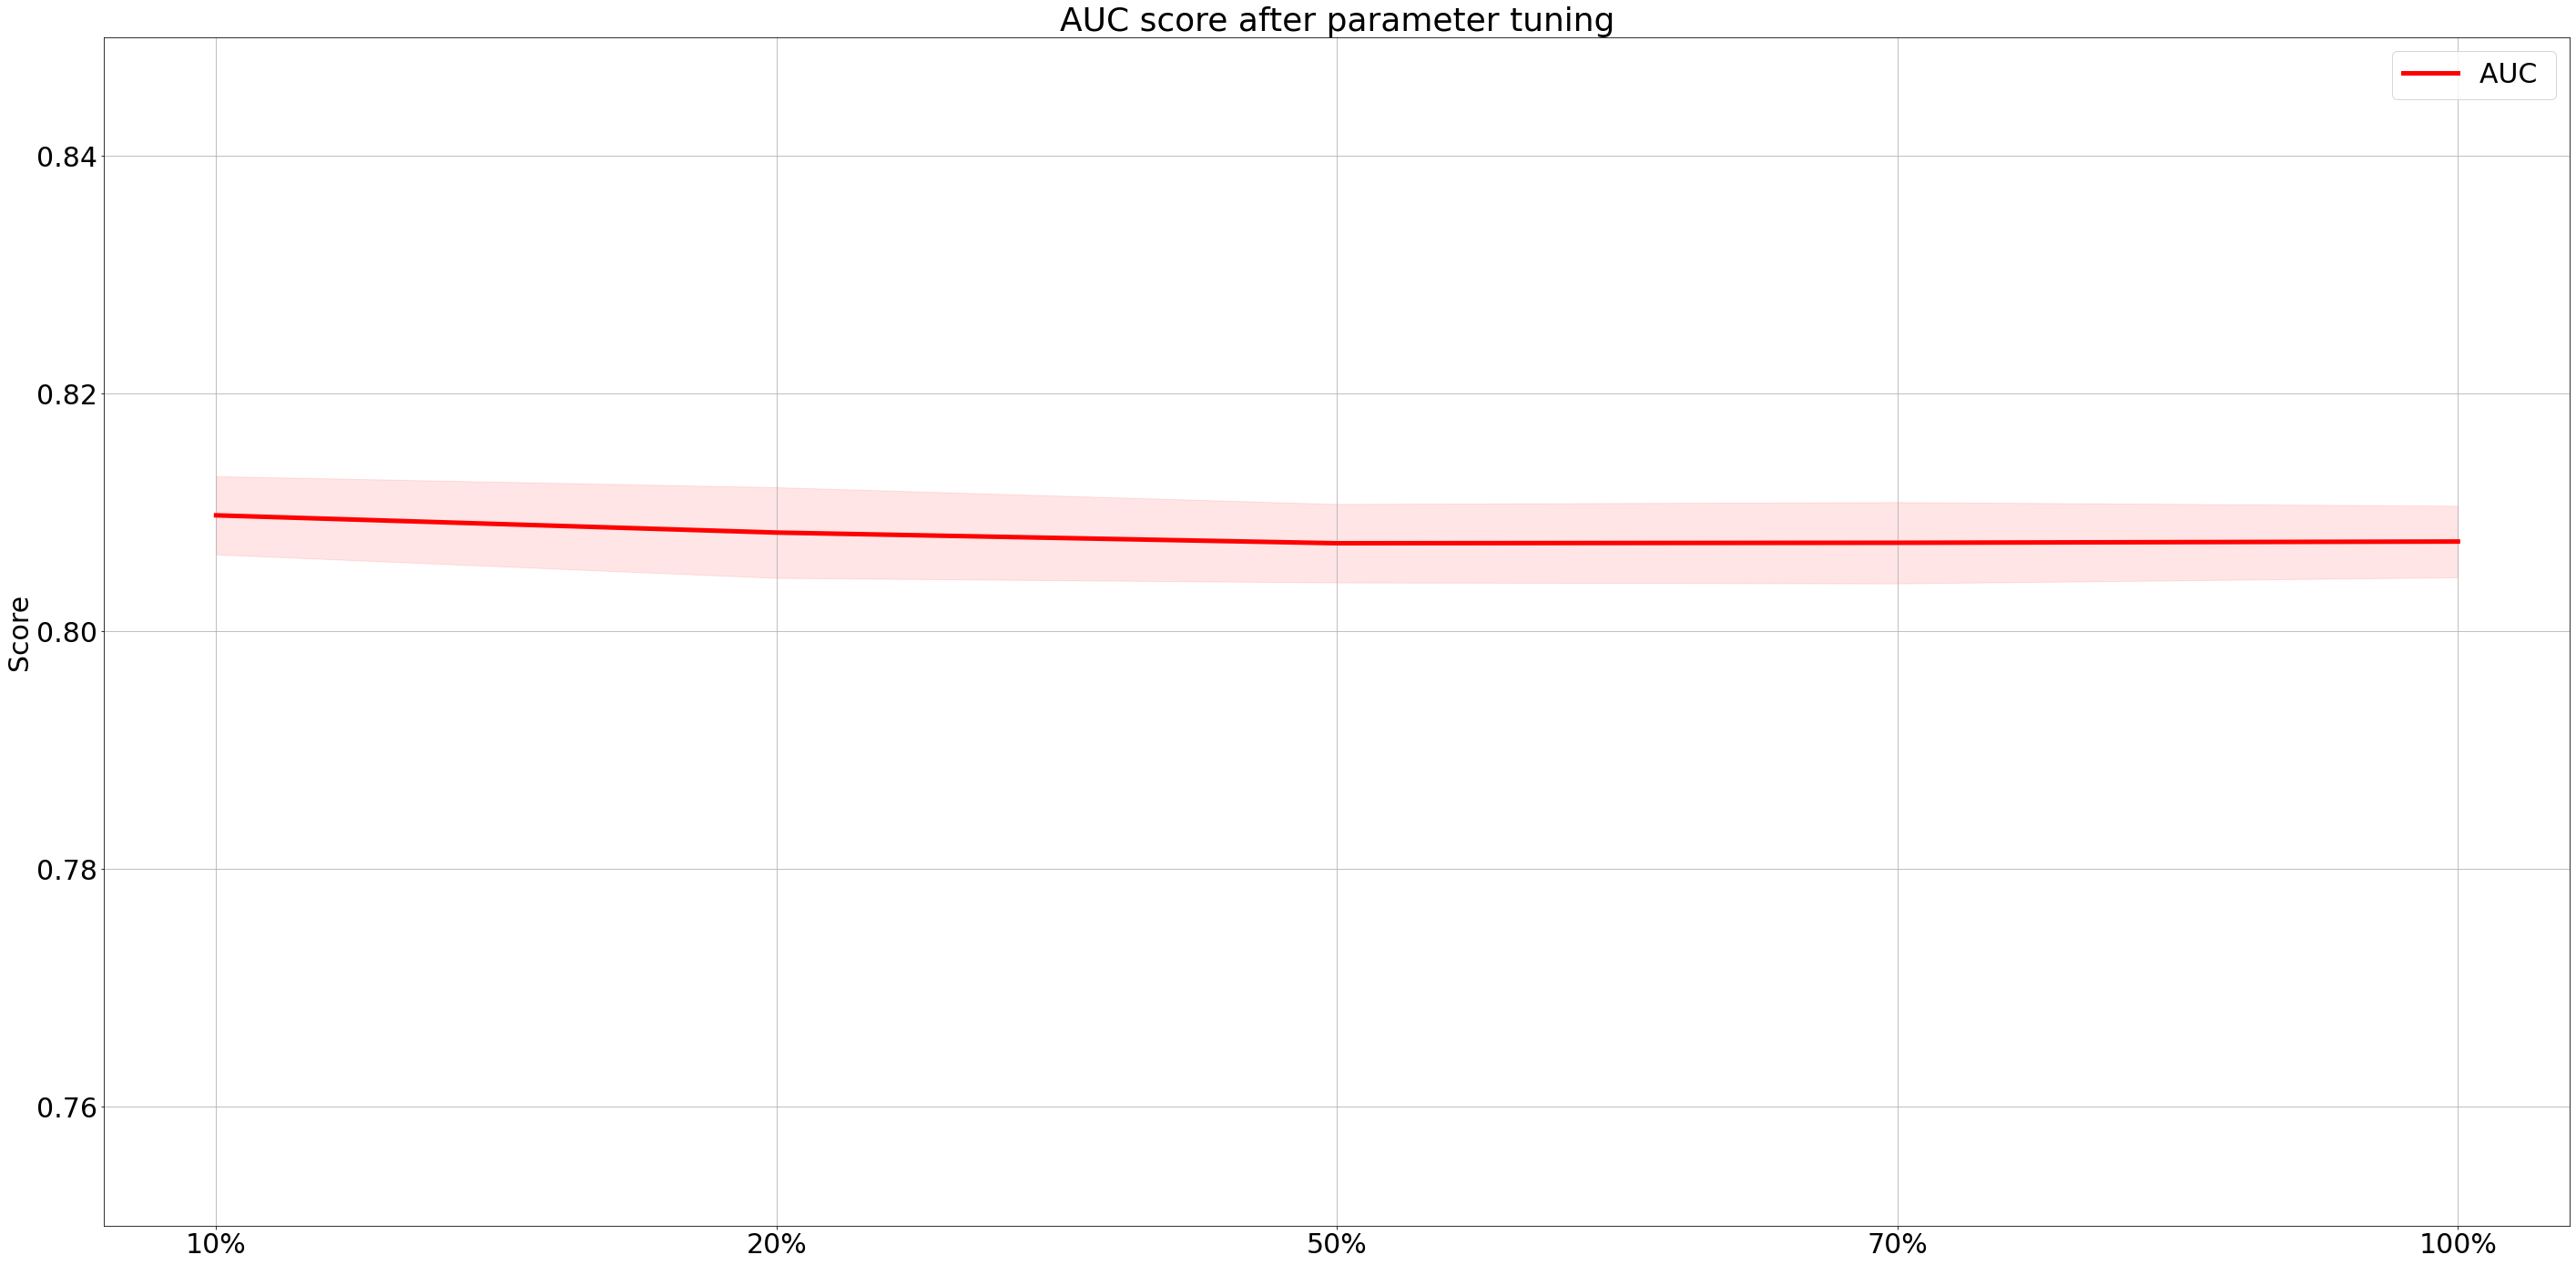

In [10]:
Y = []
Y.append((0.8097585919733324, 0.0032902212447014183))
# 0.7615084312343328 \pm 0.004667842728500686
# 0.8097585919733324 \pm 0.0032902212447014183

Y.append((0.8083069600363969, 0.003814378339180022))
# 0.7610577282162615 \pm 0.005833314667089402
# 0.8083069600363969 \pm 0.003814378339180022

Y.append((0.807408383400336, 0.0032999139284239994))
# 0.7607621067794785 \pm 0.005068633584238468
# 0.807408383400336 \pm 0.0032999139284239994

Y.append((0.8074497577708623, 0.0034199305418666334))
# 0.7610049085667185 \pm 0.00523968813112115
# 0.8074497577708623 \pm 0.0034199305418666334

Y.append((0.8075538054510369, 0.0030097956183714448))
# 0.7613021622516482 \pm 0.0046299785905639145
# 0.8075538054510369 \pm 0.0030097956183714448

Y_mean = np.array([a for a, b in Y])
Y_std_dev = np.array([b for a, b in Y])

plt.figure(figsize=(40,20))
plt.rc('font', size=30)

plt.title('AUC score after parameter tuning')
plt.ylabel("Score")
ax = plt.axes()
ax.set_ylim(0.75, 0.85)
pad = 0.005

labels = ["10%", "20%", "50%", "70%", "100%"]
colors = {'1': 'r', '2':'b', '3':'c', '4':'y'}
scorer = 'AUC'


# Y_axis = np.array([best_score_1, best_score_2, best_score_3, best_score_4])
# 
# X_axis = np.array(labels)
# Y_axis = [a for a,b in stat_auc]
# Y_std_dev = [b for a,b in stat_auc]

ax.plot(X_axis, Y_mean, '-', color=colors['1'],label="%s " % ("AUC"), linewidth=5)
ax.fill_between(X_axis, Y_mean - Y_std_dev,
                        Y_mean + Y_std_dev,
                        alpha=0.1, color=colors['1'])
# ax.plot(X_axis, Y_axis_recall, '-', color=colors['2'],label="%s " % ("Recall"), linewidth=5)

plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("IF_graph_v2_AUC_normal_data.png", dpi=100)

plt.show()

# SA

In [26]:
# dfsf = df[df["logged_in"]== 1]
print(len(df)- len(df.loc[df["target"]=='normal.']))
dfsa = df[sa_columns + ["target"]] 
# print(dfsf.head(1))
# Split the dataset into 2 classes for consistent anomaly_rate when sampling
dfsa_normal = dfsa.loc[dfsa["target"]=='normal.']

r = 0.034
target_anomaly_rate = r
n_records = int(np.ceil(len(dfsa_normal)*r/(1-r)))

dfsa_attack = df.loc[df["target"]!='normal.'].sample(n = n_records, random_state=1)

3925650


In [27]:
# 0.1 0.1

In [28]:
frac_oulier = 0.1
frac_normal = 0.1

dfsa_frac = dfsa_normal.sample(frac = frac_normal, random_state = 1).append(dfsa_attack.sample(frac = frac_oulier, random_state = 1))

anomaly_rate = 1.0 - len(dfsa_frac.loc[dfsa_frac["target"]=='normal.'])/len(dfsa_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsa_frac)} records")

dfsa_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsa_frac["target"]]
toDecode = toDecodeSA
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsa_frac[f] = leSF.fit_transform(dfsa_frac[f])
    
    
Y_source = []
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

hyperparameters = [(1, 0.25, 100),
                           (2, 0.25, 200),
                           (3, 0.25, 500),
                           (4, 0.5, 100),
                           (5, 0.5, 200),
                           (6, 0.25, 1000)]

for rs, max_samples, n_estimators in hyperparameters:
    contaminations = np.arange(0.05 - (rs * 0.005), 0.4, 0.02)
    x_train, x_test, y_train, y_test = train_test_split(dfsa_frac.drop(["target", "binary_target"], axis=1), dfsa_frac['binary_target'], test_size=0.25, random_state=rs)
    stime = time.time()
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False if rs == 1 else True)
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    Y_source.append((y_test, y_pred))
    best_param.append((rs, cmax, max_samples, n_estimators))
    print(rs, cmax, max_samples, n_estimators)

anomaly rate is 3.4% out of 100702 records
Finished trainning in 0:00:08.475088 seconds
contamination: 0.045000000000000005 	 tp: 350/support: 807/predicted: 1073 -> fp = 723
AUC : 70.2% 	 precision: 0.326 	 recall: 0.434 	 f1: 0.6739982371924305
--------------------
Finished trainning in 0:00:08.119673 seconds
contamination: 0.065 	 tp: 403/support: 807/predicted: 1572 -> fp = 1169
AUC : 72.6% 	 precision: 0.256 	 recall: 0.499 	 f1: 0.6530042684529174
--------------------
Finished trainning in 0:00:07.727646 seconds
contamination: 0.08499999999999999 	 tp: 404/support: 807/predicted: 2127 -> fp = 1723
AUC : 71.5% 	 precision: 0.19 	 recall: 0.501 	 f1: 0.6152783308798458
--------------------
Finished trainning in 0:00:07.850091 seconds
contamination: 0.105 	 tp: 404/support: 807/predicted: 2331 -> fp = 1927
AUC : 71.1% 	 precision: 0.173 	 recall: 0.501 	 f1: 0.6040695386313536
--------------------
Finished trainning in 0:00:08.204702 seconds
contamination: 0.125 	 tp: 807/support: 8

In [29]:
f1_tuned = []
auc_tuned = []
r_tuned = []

Y_source_1 = Y_source
for y_test, y_pred in Y_source:
    f  = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)

m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
stat_auc.append((m, s))
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
stat_f1.append((m, s))
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")
stat_r.append((m, s))

              precision    recall  f1-score   support

          -1       0.08      1.00      0.15       807
           1       1.00      0.63      0.77     24369

    accuracy                           0.64     25176
   macro avg       0.54      0.82      0.46     25176
weighted avg       0.97      0.64      0.75     25176

---0.754990135765767, 0.4638299276349669
---0.8162829824777381
---0.8162829824777381
              precision    recall  f1-score   support

          -1       0.09      1.00      0.16       846
           1       1.00      0.64      0.78     24330

    accuracy                           0.65     25176
   macro avg       0.54      0.82      0.47     25176
weighted avg       0.97      0.65      0.76     25176

---0.7609563528578557, 0.47215782586256116
---0.820859021783806
---0.820859021783806
              precision    recall  f1-score   support

          -1       0.09      1.00      0.16       868
           1       1.00      0.62      0.77     24308

    accuracy

In [31]:
frac_oulier = 0.1
frac_normal = 0.2

dfsa_frac = dfsa_normal.sample(frac = frac_normal, random_state = 1).append(dfsa_attack.sample(frac = frac_oulier, random_state = 1))

anomaly_rate = 1.0 - len(dfsa_frac.loc[dfsa_frac["target"]=='normal.'])/len(dfsa_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsa_frac)} records")

dfsa_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsa_frac["target"]]
toDecode = toDecodeSA
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsa_frac[f] = leSF.fit_transform(dfsa_frac[f])
    
    
Y_source = []
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

hyperparameters = [(1, 0.25, 100),
                           (2, 0.25, 200),
                           (3, 0.25, 500),
                           (4, 0.5, 100),
                           (5, 0.5, 200),
                           (6, 0.25, 1000)]

for rs, max_samples, n_estimators in hyperparameters:
    contaminations = np.arange(0.05 - (rs * 0.005), 0.4, 0.02)
    x_train, x_test, y_train, y_test = train_test_split(dfsa_frac.drop(["target", "binary_target"], axis=1), dfsa_frac['binary_target'], test_size=0.25, random_state=rs)
    stime = time.time()
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False if rs == 1 else True)
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    Y_source.append((y_test, y_pred))
    best_param.append((rs, cmax, max_samples, n_estimators))
    print(rs, cmax, max_samples, n_estimators)
    
f1_tuned = []
auc_tuned = []
r_tuned = []

Y_source_1 = Y_source
for y_test, y_pred in Y_source:
    f  = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)

m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
stat_auc.append((m, s))
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
stat_f1.append((m, s))
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")
stat_r.append((m, s))

anomaly rate is 1.7% out of 197980 records
Finished trainning in 0:00:17.418979 seconds
contamination: 0.045000000000000005 	 tp: 410/support: 843/predicted: 2152 -> fp = 1742
AUC : 72.5% 	 precision: 0.191 	 recall: 0.486 	 f1: 0.6255661096706049
--------------------
Finished trainning in 0:00:15.545975 seconds
contamination: 0.065 	 tp: 843/support: 843/predicted: 3182 -> fp = 2339
AUC : 97.6% 	 precision: 0.265 	 recall: 1.0 	 f1: 0.697125930344393
--------------------
Finished trainning in 0:00:15.956687 seconds
contamination: 0.08499999999999999 	 tp: 843/support: 843/predicted: 4161 -> fp = 3318
AUC : 96.6% 	 precision: 0.203 	 recall: 1.0 	 f1: 0.6508136626910248
--------------------
Finished trainning in 0:00:16.363566 seconds
contamination: 0.105 	 tp: 843/support: 843/predicted: 5179 -> fp = 4336
AUC : 95.5% 	 precision: 0.163 	 recall: 1.0 	 f1: 0.6166668633848679
--------------------
Finished trainning in 0:00:16.400438 seconds
contamination: 0.125 	 tp: 843/support: 843/pr

In [ ]:
frac_oulier = 0.1
frac_normal = 0.5
dfsa_frac = dfsa_normal.sample(frac = frac_normal, random_state = 1).append(dfsa_attack.sample(frac = frac_oulier, random_state = 1))

anomaly_rate = 1.0 - len(dfsa_frac.loc[dfsa_frac["target"]=='normal.'])/len(dfsa_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsa_frac)} records")

dfsa_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsa_frac["target"]]
toDecode = toDecodeSA
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsa_frac[f] = leSF.fit_transform(dfsa_frac[f])
    
    
Y_source = []
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

hyperparameters = [(1, 0.25, 100),
                           (2, 0.25, 200),
                           (3, 0.25, 500),
                           (4, 0.5, 100),
                           (5, 0.5, 200),
                           (6, 0.25, 1000)]

for rs, max_samples, n_estimators in hyperparameters:
    contaminations = np.arange(0.05 - (rs * 0.005), 0.4, 0.02)
    x_train, x_test, y_train, y_test = train_test_split(dfsa_frac.drop(["target", "binary_target"], axis=1), dfsa_frac['binary_target'], test_size=0.25, random_state=rs)
    stime = time.time()
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False if rs == 1 else True)
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    Y_source.append((y_test, y_pred))
    best_param.append((rs, cmax, max_samples, n_estimators))
    print(rs, cmax, max_samples, n_estimators)
    
f1_tuned = []
auc_tuned = []
r_tuned = []

Y_source_1 = Y_source
for y_test, y_pred in Y_source:
    f  = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)

m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
stat_auc.append((m, s))
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
stat_f1.append((m, s))
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")
stat_r.append((m, s))

In [ ]:
frac_oulier = 0.1
frac_normal = 0.7

dfsa_frac = dfsa_normal.sample(frac = frac_normal, random_state = 1).append(dfsa_attack.sample(frac = frac_oulier, random_state = 1))

anomaly_rate = 1.0 - len(dfsa_frac.loc[dfsa_frac["target"]=='normal.'])/len(dfsa_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsa_frac)} records")

dfsa_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsa_frac["target"]]
toDecode = toDecodeSA
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsa_frac[f] = leSF.fit_transform(dfsa_frac[f])
    
    
Y_source = []
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

hyperparameters = [(1, 0.25, 100),
                           (2, 0.25, 200),
                           (3, 0.25, 500),
                           (4, 0.5, 100),
                           (5, 0.5, 200),
                           (6, 0.25, 1000)]

for rs, max_samples, n_estimators in hyperparameters:
    contaminations = np.arange(0.05 - (rs * 0.005), 0.4, 0.02)
    x_train, x_test, y_train, y_test = train_test_split(dfsa_frac.drop(["target", "binary_target"], axis=1), dfsa_frac['binary_target'], test_size=0.25, random_state=rs)
    stime = time.time()
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False if rs == 1 else True)
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    Y_source.append((y_test, y_pred))
    best_param.append((rs, cmax, max_samples, n_estimators))
    print(rs, cmax, max_samples, n_estimators)
    
f1_tuned = []
auc_tuned = []
r_tuned = []

Y_source_1 = Y_source
for y_test, y_pred in Y_source:
    f  = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)

m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
stat_auc.append((m, s))
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
stat_f1.append((m, s))
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")
stat_r.append((m, s))

In [ ]:
frac_oulier = 0.1
frac_normal = 1.0

dfsa_frac = dfsa_normal.sample(frac = frac_normal, random_state = 1).append(dfsa_attack.sample(frac = frac_oulier, random_state = 1))

anomaly_rate = 1.0 - len(dfsa_frac.loc[dfsa_frac["target"]=='normal.'])/len(dfsa_frac)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(dfsa_frac)} records")

dfsa_frac['binary_target'] = [1 if x=='normal.' else -1 for x in dfsa_frac["target"]]
toDecode = toDecodeSA
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    dfsa_frac[f] = leSF.fit_transform(dfsa_frac[f])
    
    
Y_source = []
Y_axis_f1 = []
Y_axis_recall = []
Y_axis_auc = []
best_param = []

hyperparameters = [(1, 0.25, 100),
                           (2, 0.25, 200),
                           (3, 0.25, 500),
                           (4, 0.5, 100),
                           (5, 0.5, 200),
                           (6, 0.25, 1000)]

for rs, max_samples, n_estimators in hyperparameters:
    contaminations = np.arange(0.05 - (rs * 0.005), 0.4, 0.02)
    x_train, x_test, y_train, y_test = train_test_split(dfsa_frac.drop(["target", "binary_target"], axis=1), dfsa_frac['binary_target'], test_size=0.25, random_state=rs)
    stime = time.time()
    cmax, y_pred, f, fp, tp, p, r, t = cross_validation(contaminations, max_samples, n_estimators, rs, silent=False if rs == 1 else True)
    print("Time for IF fitting: %.3f" % (time.time() - stime))
    Y_source.append((y_test, y_pred))
    best_param.append((rs, cmax, max_samples, n_estimators))
    print(rs, cmax, max_samples, n_estimators)
    
f1_tuned = []
auc_tuned = []
r_tuned = []

Y_source_1 = Y_source
for y_test, y_pred in Y_source:
    f  = f1_score(y_test, y_pred, average = 'weighted')
    fm = f1_score(y_test, y_pred, average = 'macro')
    print(classification_report(y_test, y_pred))
    print(f"---{f}, {fm}")
    f1_tuned.append(f)
    a = roc_auc_score(y_test, y_pred)
    print(f"---{a}")
    auc_tuned.append(a)
    r = recall_score(y_test, y_pred, average = 'macro')
    print(f"---{r}")
    r_tuned.append(r)

m = statistics.mean(auc_tuned)
s = statistics.stdev(auc_tuned)
print(f"{m} \pm {s}")
stat_auc.append((m, s))
m = statistics.mean(f1_tuned)
s = statistics.stdev(f1_tuned)
print(f"{m} \pm {s}")
stat_f1.append((m, s))
m = statistics.mean(r_tuned)
s = statistics.stdev(r_tuned)
print(f"{m} \pm {s}")
stat_r.append((m, s))

In [ ]:
plt.figure(figsize=(40,20))
plt.rc('font', size=30)

plt.title('AUC score after parameter tuning')
plt.ylabel("Score")
ax = plt.axes()
# ax.set_ylim(0.8, 1)
pad = 0.005

labels = ["10%", "20%", "50%", "70%", "100%"]
colors = {'1': 'r', '2':'b', '3':'c', '4':'y'}
scorer = 'AUC'


# Y_axis = np.array([best_score_1, best_score_2, best_score_3, best_score_4])
# 
X_axis = np.array(labels)
Y_axis = [a for a,b in stat_auc]
Y_std_dev = [b for a,b in stat_auc]

ax.plot(X_axis, Y_axis, '-', color=colors['1'],label="%s " % ("AUC"), linewidth=5)
# ax.plot(X_axis, Y_axis_recall, '-', color=colors['2'],label="%s " % ("Recall"), linewidth=5)

plt.legend(loc="best")
plt.grid('off')
plt.tight_layout()
plt.savefig("IF_graph_v2_AUC_normal_data.png", dpi=100)

plt.show()